# Part III: Model Hyperparameter Tuning for Left Right Fingerprints

Hyperparameters are the variables that govern the training process and the topology of an ML model. These variables remain constant over the training process and directly impact the performance of your ML program. Hyperparameters are of two types:

1. Model hyperparameters which influence model selection such as the number and width of hidden layers
1. Algorithm hyperparameters which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier

Here are some strategies you can consider while hyperparameter tuning to improve performance:

1. Model Complexity
2. Hyperparameter Tuning
3. Data Augmentation
4. Transfer Learning
5. Ensemble Methods
6. Advanced Techniques

The following code will use Keras Hyperband tuning algorithm for adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. [Learn more about tuning here](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [1]:
! pip install -r ../requirements.txt -q

In [20]:
import os
import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt

# Set scratch directory
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

# Define image dataset creation function
def create_image_dataset(directory, color_mode="grayscale", validation_split=0.2,
                         subset=None, seed=123, image_size=(96, 96), batch_size=32):
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        color_mode=color_mode,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )
    dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Load train and validation datasets
train_ds = create_image_dataset(
    scratch_path + '/processed/hand',
    subset="training",
)
val_ds = create_image_dataset(
    scratch_path + '/processed/hand',
    subset="validation",
)

# Define model creation function for hyperparameter tuning
def create_hp_model(hp):
    class_names = ['left', 'right']  # Define default class names here
    num_classes = len(class_names)

    # Define hyperparameters to tune
    hp_filters_1 = hp.Int('filters_1', min_value=16, max_value=64, step=16)
    hp_filters_2 = hp.Int('filters_3', min_value=64, max_value=256, step=64)
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    
    # Define the model architecture
    model = tf.keras.Sequential([
        layers.Conv2D(hp_filters_1, 3, padding='same', activation='relu', input_shape=(96, 96, 1)),
        layers.MaxPooling2D(),
        layers.Conv2D(hp_filters_2, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(hp_filters_2, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(hp_filters_2, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(hp_dense_units, activation='relu'),
        layers.Dense(num_classes)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

# Perform hyperparameter tuning with Hyperband tuner
tuner = kt.Hyperband(
    create_hp_model,
    max_epochs=10,
    objective='val_accuracy',
    factor=3,
    directory=scratch_path + '/models',
    project_name='model_tuning'
)

# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Define a callback to print best value so far
class PrintBestValue(tf.keras.callbacks.Callback):
    def on_trial_end(self, trial, logs=None):
        print(f"Best val_accuracy So Far: {self.model.oracle.get_best_trials(1)[0].score}")
        
tuner.search(train_ds, validation_data=val_ds, epochs=10, batch_size=32, callbacks=[PrintBestValue()])

# Get best hyperparameters and build the model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

# Train the best model with the obtained best hyperparameters
history = best_model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32, callbacks=[stop_early])

env: SCRATCH=../scratch
Found 17953 files belonging to 2 classes.
Using 14363 files for training.
Found 17953 files belonging to 2 classes.
Using 3590 files for validation.
Reloading Tuner from ../scratch/models/model_tuning/tuner0.json
Epoch 1/10
449/449 [==============================] - 6s 8ms/step - loss: 1.2143 - accuracy: 0.7197 - val_loss: 0.4526 - val_accuracy: 0.7905
Epoch 2/10
449/449 [==============================] - 3s 8ms/step - loss: 0.4005 - accuracy: 0.8174 - val_loss: 0.3849 - val_accuracy: 0.8209
Epoch 3/10
449/449 [==============================] - 3s 8ms/step - loss: 0.3516 - accuracy: 0.8440 - val_loss: 0.3444 - val_accuracy: 0.8454
Epoch 4/10
449/449 [==============================] - 3s 8ms/step - loss: 0.3118 - accuracy: 0.8615 - val_loss: 0.3138 - val_accuracy: 0.8618
Epoch 5/10
449/449 [==============================] - 3s 8ms/step - loss: 0.2723 - accuracy: 0.8821 - val_loss: 0.2966 - val_accuracy: 0.8721
Epoch 6/10
449/449 [==============================] -

Overall, a low training loss and high accuracy along with reasonably close validation metrics indicate that the model is learning well and has a decent ability to generalize to new data.

## Performance Visualization Function

This function, plot_training_history, takes in the history object returned by the model's fit method and the epochs parameter. It then plots the training and validation accuracy as well as the training and validation loss in two subplots, providing insights into the model's performance during training.

In [21]:
import matplotlib.pyplot as plt
import os
from datetime import datetime

def plot_training_history(history, epochs, save_dir=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    # Save the plot to a directory if specified
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        plot_filename = f"tuning_history_plot_{current_time}.png"
        plot_path = os.path.join(save_dir, plot_filename)
        
        plt.savefig(plot_path)
        print(f"Plot saved to: {plot_path}")
    
    # Show the plot
    plt.show()

In [ ]:
# Execute the performance visualization
plot_training_history(history=trained_history, epochs=10, save_dir='../reports/')

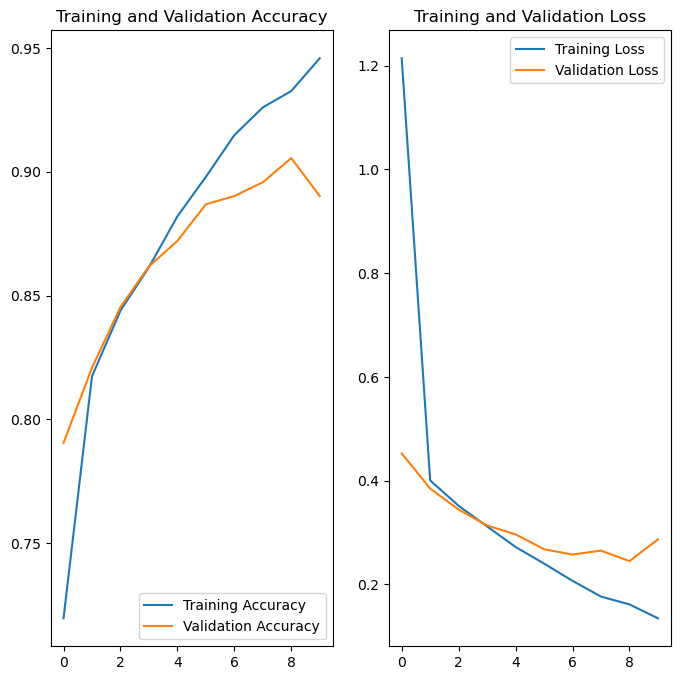

In [24]:
# Execute the performance visualization
plot_training_history(history=history, epochs=10)

# Serialize Model

In [25]:
# note: tf.saved_model.save(model, path_to_dir)
model_version = os.environ.get('VERSION', "2")

model_path = scratch_path + "/models/hand/" + model_version + "/model.savedmodel"
best_model.save(model_path)

INFO:tensorflow:Assets written to: ../scratch/models/hand/2/model.savedmodel/assets


INFO:tensorflow:Assets written to: ../scratch/models/hand/2/model.savedmodel/assets


## Load the tuned model

In [26]:
import keras

model = keras.models.load_model(model_path)

# Test with a sample

Files in path: 6000
Selected: 26__M_Left_middle_finger.png
shape: (1, 96, 96, 1)


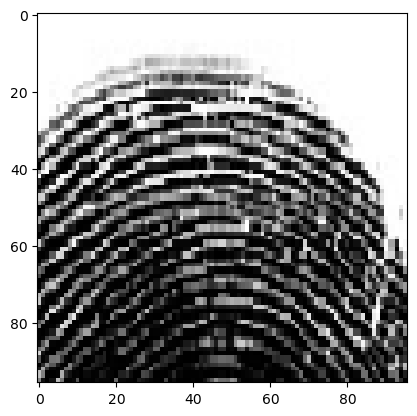

In [27]:
# select random images
import random
import matplotlib.pyplot as plt

samples_path = scratch_path + "/processed/real/"
file_list = os.listdir(samples_path)
print('Files in path: ' + str(len(file_list)))

test_image = random.choice(file_list)
print('Selected: ' + test_image)

# loads an image into PIL format.
img = tf.keras.utils.load_img(
    samples_path + test_image,
    color_mode="grayscale",
    target_size=(96, 96),
    #interpolation='nearest',
)

plt.imshow(img, cmap='gray')

# converts a PIL image instance to a numpy array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print("shape:",img_array.shape)

## Generate Predictions

In [28]:
import numpy as np

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_mapping = {0: 'left', 1: 'right'}  # Define your class mapping

predicted_label = class_mapping[np.argmax(score)]
confidence = 100 * np.max(score)

print(
    f"This image {test_image} is predicted as {predicted_label} with a {confidence:.2f}% confidence."
)

# Check if the predicted label is in the test image name (case insensitive)
is_label_in_image_name = predicted_label.lower() in test_image.lower()
print(f"Is predicted label in the image name? {is_label_in_image_name}")

1/1 [==============================] - 0s 96ms/step
This image 26__M_Left_middle_finger.png is predicted as left with a 99.12% confidence.
Is predicted label in the image name? True


# Upload to S3

In [29]:
# list objects using the aws s3 cli
! aws s3 ls

2023-11-21 19:33:30 managed-velero-backups-736247ed-2c46-4068-825b-be42f54d5ac3
2023-11-16 22:36:17 rosa-n6wkj-cjkpb-image-registry-us-east-2-wbgvottmvhgatruvbiyd
2023-11-18 14:58:53 sagemaker-fingerprint-data-n6wkj


In [30]:
# List the dynamically created bucket for the demo
import boto3

s3_client = boto3.client('s3')
response = s3_client.list_buckets()

filtered_buckets=[]

for bucket in response['Buckets']:
    bucket_name = bucket['Name']
    if bucket_name.startswith('sagemaker-fingerprint-'):
        filtered_buckets.append(bucket_name)
    
print(filtered_buckets)

['sagemaker-fingerprint-data-n6wkj']


In [31]:
# Upload the model to the demo bucket
import subprocess

for bucket in filtered_buckets:
    command = f"aws s3 sync ../scratch/models/hand s3://{bucket}/models/hand"
    subprocess.run(command, shell=True)

upload: ../scratch/models/hand/2/model.savedmodel/fingerprint.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/2/model.savedmodel/fingerprint.pb
upload: ../scratch/models/hand/2/model.savedmodel/variables/variables.index to s3://sagemaker-fingerprint-data-n6wkj/models/hand/2/model.savedmodel/variables/variables.index
upload: ../scratch/models/hand/2/model.savedmodel/keras_metadata.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/2/model.savedmodel/keras_metadata.pb
upload: ../scratch/models/hand/2/model.savedmodel/saved_model.pb to s3://sagemaker-fingerprint-data-n6wkj/models/hand/2/model.savedmodel/saved_model.pb
upload: ../scratch/models/hand/2/model.savedmodel/variables/variables.data-00000-of-00001 to s3://sagemaker-fingerprint-data-n6wkj/models/hand/2/model.savedmodel/variables/variables.data-00000-of-00001
